In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.signal import savgol_filter
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq
from scipy.signal import savgol_filter
from corrLib import boxsize_effect_spatial
import matplotlib as mpl
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import polyvander
%matplotlib nbagg

<IPython.core.display.Javascript object>


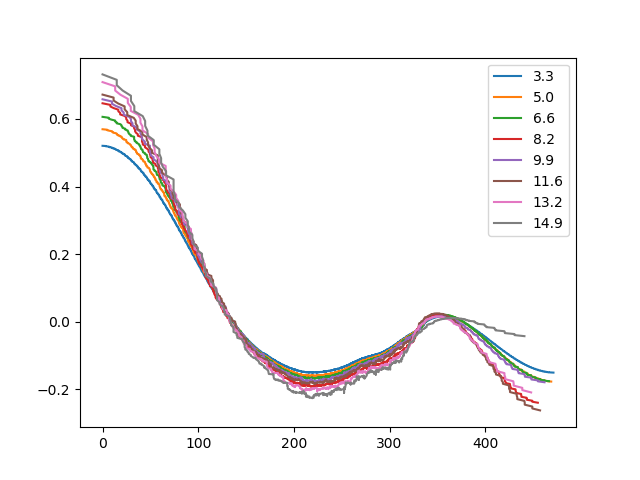

In [12]:
%matplotlib nbagg
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\0001.tif')
boxsize = range(10, 50, 5)
mpp= 0.33
data = boxsize_effect_spatial(img, boxsize, mpp)

<IPython.core.display.Javascript object>


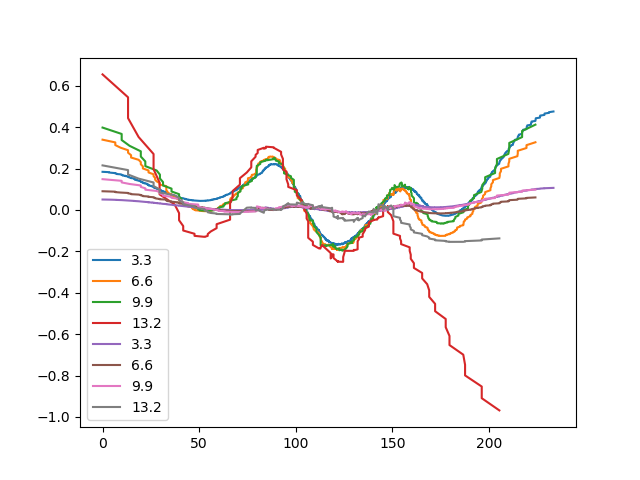

In [40]:
%matplotlib nbagg
boxsize = range(10, 50, 10)
mpp= 0.33
imgDirs = dirrec(r'I:\Github\Python\Correlation\test_images\test_cl', '*.tif')
for imgDir in imgDirs:
    if imgDir == r'I:\Github\Python\Correlation\test_images\boxsize_effect\0001.tif':
        continue
    img = io.imread(imgDir)
    data = boxsize_effect_spatial(img, boxsize, mpp)
    folder, file = os.path.split(imgDir)
    name, ext = os.path.splitext(file)
    imgData = pd.DataFrame()
    for kw in data:
        subdata = data[kw].assign(boxsize_um=kw)
        imgData = imgData.append(subdata)
    imgData.to_csv(os.path.join(folder, name+'_data.csv'), index=False)

In [4]:
folder, file = os.path.split(r'I:\Github\Python\Correlation\test_images\boxsize_effect\0001.tif')

<IPython.core.display.Javascript object>


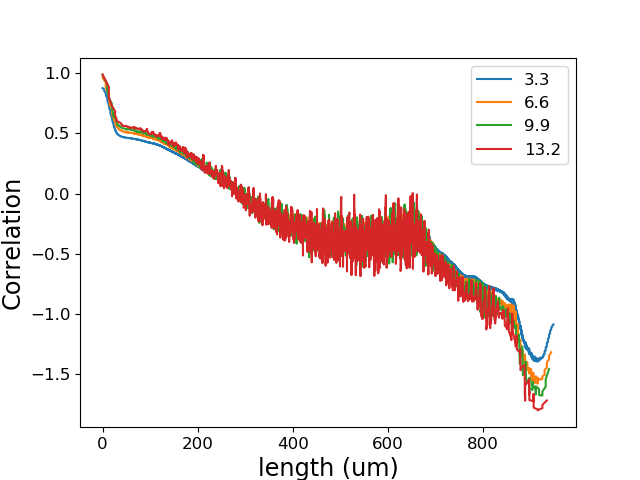

In [2]:
%matplotlib nbagg
name = '80-2'
folder = r'E:\Github\Python\Correlation\test_images\boxsize_effect'
dataDir = os.path.join(folder, name + '_data.csv')
data = pd.read_csv(dataDir)
for bs in data.boxsize_um.drop_duplicates():
    subdata = data.loc[data.boxsize_um==bs]
    length = len(subdata)
    smooth_length = int(np.ceil(length/500)*2+1)
    plt.plot(subdata.R, savgol_filter(subdata.C, smooth_length, 3), label=bs)
plt.legend()
plt.xlabel('length (um)')
plt.ylabel('Correlation')
plt.savefig(os.path.join(folder, name+'_cl.png'))

<IPython.core.display.Javascript object>


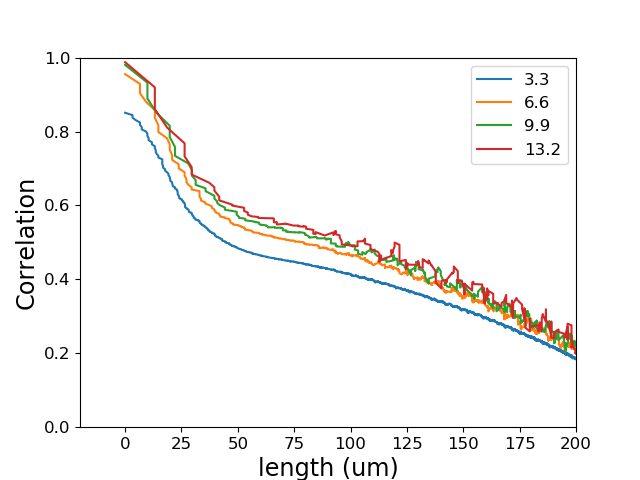

[-20, 200, 0, 1]

In [3]:
%matplotlib nbagg
name = '80-1'
folder = r'E:\Github\Python\Correlation\test_images\boxsize_effect'
dataDir = os.path.join(folder, name + '_data.csv')
data = pd.read_csv(dataDir)
for bs in data.boxsize_um.drop_duplicates():
    subdata = data.loc[data.boxsize_um==bs]
    length = len(subdata)
    smooth_length = int(np.ceil(length/500)*2+1)
    plt.plot(subdata.R, savgol_filter(subdata.C, smooth_length, 3), label=bs)
plt.legend()
plt.xlabel('length (um)')
plt.ylabel('Correlation')
plt.axis([-20, 200, 0, 1])
# plt.savefig(os.path.join(folder, 'cl_zoom_'+name+'_.png'), dpi=300)

## Locate turning point

* original curve

<IPython.core.display.Javascript object>


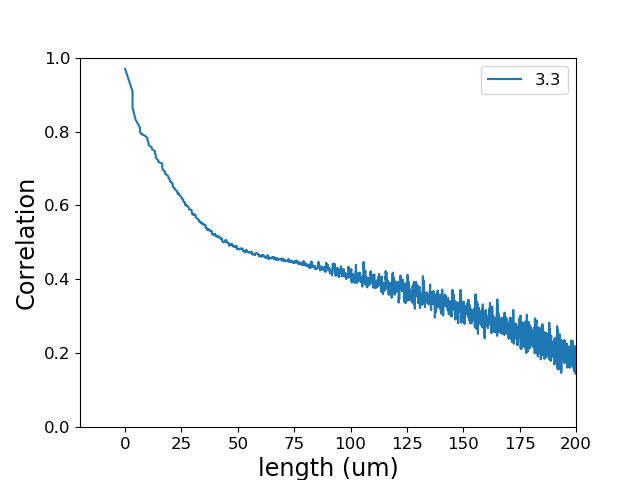

[-20, 200, 0, 1]

In [30]:
%matplotlib nbagg
name = '80-1'
folder = r'E:\Github\Python\Correlation\test_images\boxsize_effect'
dataDir = os.path.join(folder, name + '_data.csv')
data = pd.read_csv(dataDir)
for bs in data.boxsize_um.drop_duplicates():
    subdata = data.loc[data.boxsize_um==bs]
    subdata = subdata.loc[subdata.R<200]
    break
length = len(subdata)
smooth_length = int(np.ceil(length/500)*2+1)
plt.plot(subdata.R, savgol_filter(subdata.C, smooth_length, 3), label=bs)
plt.legend()
plt.xlabel('length (um)')
plt.ylabel('Correlation')
plt.axis([-20, 200, 0, 1])

* Polynomial fitting to 5th order

In [5]:
x = np.array(subdata.R)
y = savgol_filter(subdata.C, smooth_length, 3)

<IPython.core.display.Javascript object>


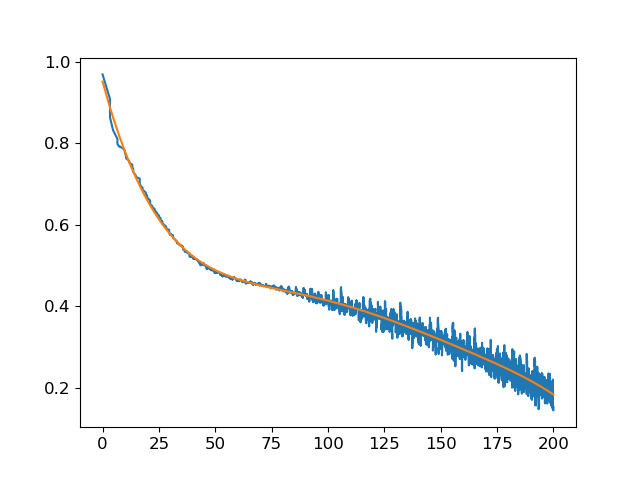

In [7]:
# polynomial fitting
deg = 5
plt.plot(x, y)
p = np.polyfit(x, y, deg)
yf = np.matmul(polyvander(x, deg), np.flip(p.transpose()))
plt.plot(x, yf)

<IPython.core.display.Javascript object>


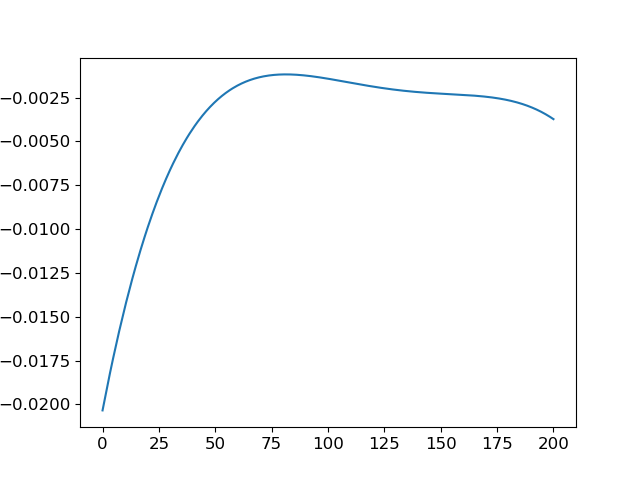

In [8]:
# d1
po = np.poly1d(p)
p3 = np.polyder(po, 1)
p3 = np.array(p3)
y3 = np.matmul(polyvander(x, deg-1), np.flip(p3.transpose()))
plt.plot(x, y3)

<IPython.core.display.Javascript object>


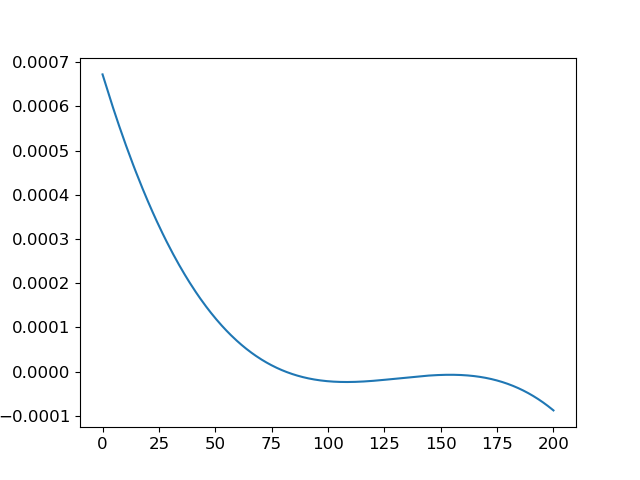

In [9]:
# d2
d = 2
po = np.poly1d(p)
p3 = np.polyder(po, d)
p3 = np.array(p3)
y3 = np.matmul(polyvander(x, deg-d), np.flip(p3.transpose()))
plt.plot(x, y3)

<IPython.core.display.Javascript object>


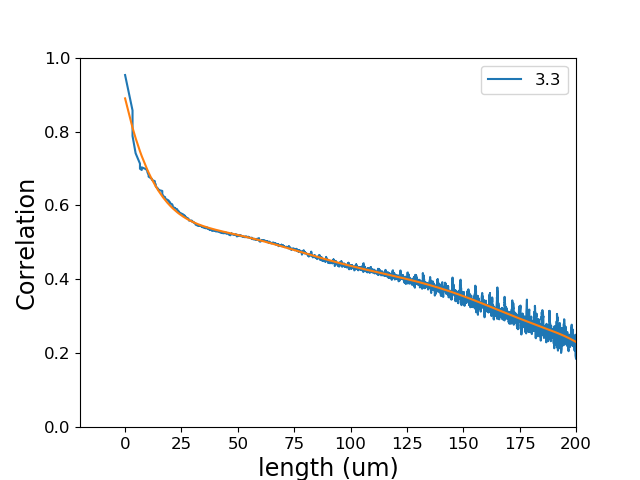

In [40]:
%matplotlib nbagg
name = '60-1'
folder = r'E:\Github\Python\Correlation\test_images\boxsize_effect'
dataDir = os.path.join(folder, name + '_data.csv')
data = pd.read_csv(dataDir)
for bs in data.boxsize_um.drop_duplicates():
    subdata = data.loc[data.boxsize_um==bs]
    subdata = subdata.loc[subdata.R<200]
    break
length = len(subdata)
smooth_length = int(np.ceil(length/500)*2+1)
plt.plot(subdata.R, savgol_filter(subdata.C, smooth_length, 3), label=bs)
plt.legend()
plt.xlabel('length (um)')
plt.ylabel('Correlation')
plt.axis([-20, 200, 0, 1])

x = np.array(subdata.R)
y = savgol_filter(subdata.C, smooth_length, 3)
# polynomial fitting
deg = 9
p = np.polyfit(x, y, deg)
yf = np.matmul(polyvander(x, deg), np.flip(p.transpose()))
plt.plot(x, yf)

<IPython.core.display.Javascript object>


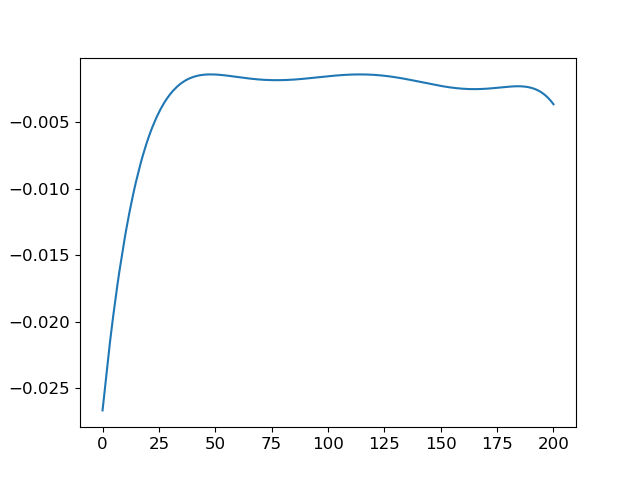

In [43]:
# d1
d = 1
po = np.poly1d(p)
p3 = np.polyder(po, d)
p3 = np.array(p3)
y3 = np.matmul(polyvander(x, deg-d), np.flip(p3.transpose()))
plt.plot(x, y3)

<IPython.core.display.Javascript object>


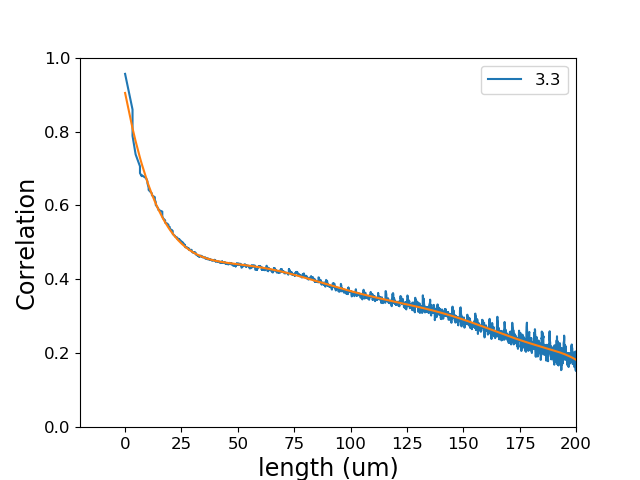

In [37]:
%matplotlib nbagg
name = '60-2'
folder = r'E:\Github\Python\Correlation\test_images\boxsize_effect'
dataDir = os.path.join(folder, name + '_data.csv')
data = pd.read_csv(dataDir)
for bs in data.boxsize_um.drop_duplicates():
    subdata = data.loc[data.boxsize_um==bs]
    subdata = subdata.loc[subdata.R<200]
    break
length = len(subdata)
smooth_length = int(np.ceil(length/500)*2+1)
plt.plot(subdata.R, savgol_filter(subdata.C, smooth_length, 3), label=bs)
plt.legend()
plt.xlabel('length (um)')
plt.ylabel('Correlation')
plt.axis([-20, 200, 0, 1])

x = np.array(subdata.R)
y = savgol_filter(subdata.C, smooth_length, 3)
# polynomial fitting
deg = 9
p = np.polyfit(x, y, deg)
yf = np.matmul(polyvander(x, deg), np.flip(p.transpose()))
plt.plot(x, yf)

<IPython.core.display.Javascript object>


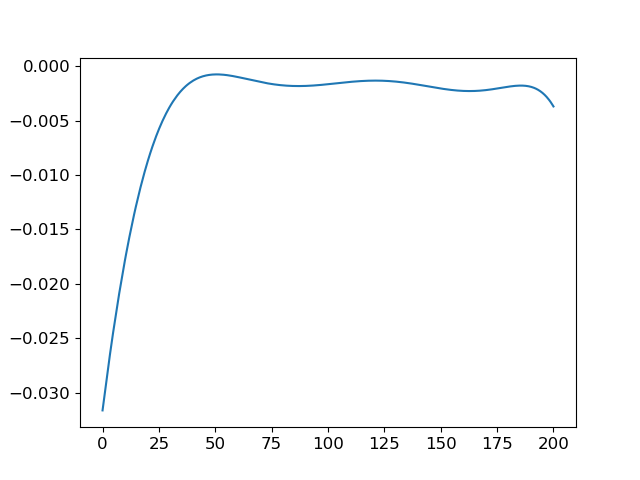

In [38]:
# d1
d = 1
po = np.poly1d(p)
p3 = np.polyder(po, d)
p3 = np.array(p3)
y3 = np.matmul(polyvander(x, deg-d), np.flip(p3.transpose()))
plt.plot(x, y3)

<IPython.core.display.Javascript object>


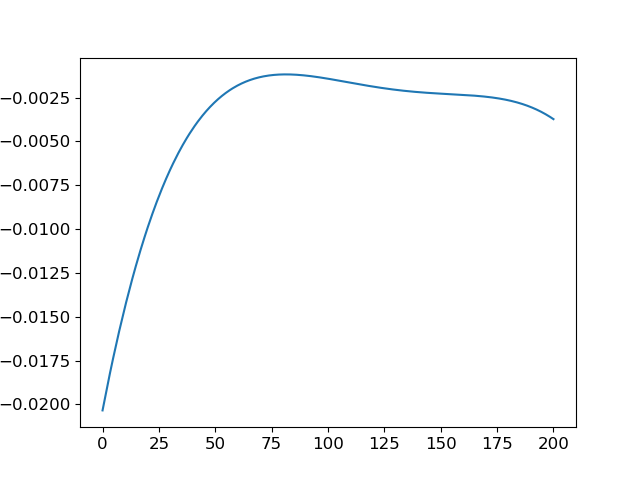

In [25]:
# d1
po = np.poly1d(p)
p3 = np.polyder(po, 1)
p3 = np.array(p3)
y3 = np.matmul(polyvander(x, deg-1), np.flip(p3.transpose()))
plt.plot(x, y3)

### FFT for characteristic length

In [11]:
img = io.imread(r'E:\Github\Python\Correlation\test_images\boxsize_effect\80-2.tif')
fft = np.fft.fft2(img)
ffts = np.fft.fftshift(fft)

<IPython.core.display.Javascript object>


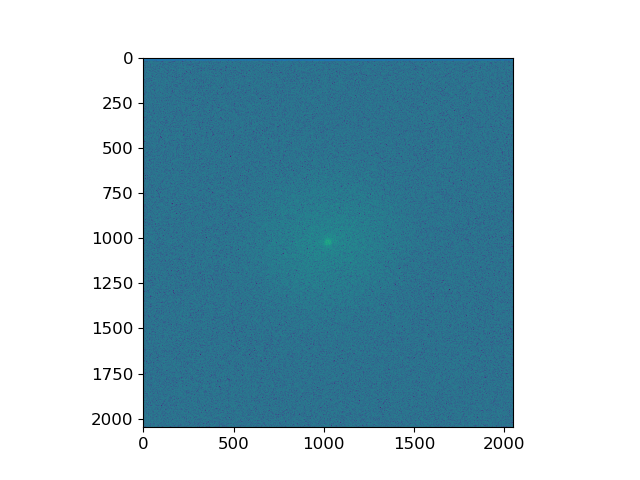

In [17]:
plt.imshow(np.log(abs(ffts)))

<IPython.core.display.Javascript object>


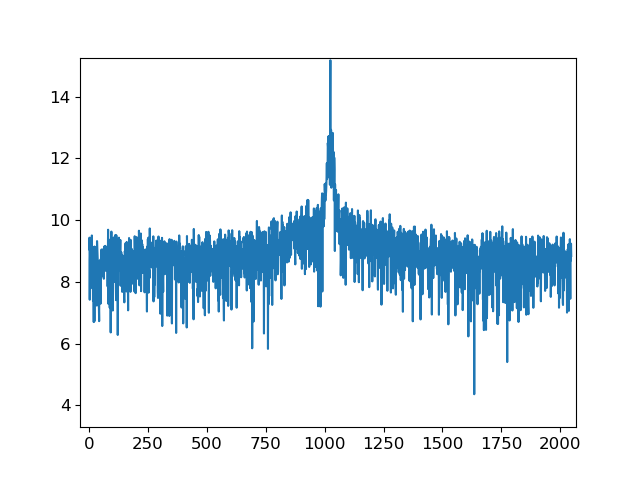

In [19]:
plt.plot(np.log(abs(ffts))[1023, :])

## Giant number fluctuation analysis

In [15]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\0001.tif')
boxsize = np.unique(np.floor(np.logspace(0, 2.5, 100)))
NList = []
dNList = []
for bs in boxsize:
    X, Y, I = divide_windows(img, windowsize=[bs, bs], step=bs)
    N = (255-I.mean())*bs*bs
    dN = I.std()*bs*bs
    NList.append(N)
    dNList.append(dN)

In [1]:
n = np.array(NList)
d = np.array(dNList)
plt.plot(n, d/n**.5)
plt.xscale('log')
plt.yscale('log')

NameError: name 'np' is not defined

### Analyze density fluctuation of an 8-bit grayscale image

In [11]:
def density_fluctuation(img8):
    # Gradually increase box size and calculate dN=std(I) and N=mean(I)
    row, col = img8.shape
    # choose maximal box size to be 1/3 of the shorter edge of the image 
    # to guarantee we have multiple boxes for each calculation, so that
    # the statistical quantities are meaningful.
    l = min(row, col)
    boxsize = np.unique(np.floor(np.logspace(0, np.log10(l/3), 100)))
    NList = []
    dNList = []
    for bs in boxsize:
        X, Y, I = divide_windows(img, windowsize=[bs, bs], step=bs)
        N = (255-I.mean())*bs*bs
        dN = I.std()*bs*bs
        NList.append(N)
        dNList.append(dN)
    return NList, dNList

In [12]:
img = io.imread(r'I:\Github\Python\Correlation\test_images\boxsize_effect\0001.tif')
n, d = density_fluctuation(img)

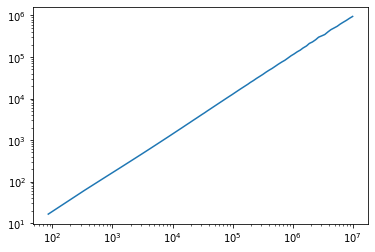

In [14]:
plt.plot(n, d)
plt.xscale('log')
plt.yscale('log')